In [11]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score,cohen_kappa_score, accuracy_score
from scipy import stats

aspects = [ 'actionability', 'grounding_specificity', 'verifiability', 'helpfulness']
# aspects = [ 'actionability', 'grounding_specificity', 'helpfulness']

# aspects = [ 'actionability']
types = ['definitions', 'definitions_examples', 'definitions_incontext_learning']
data_type = 'gold'
results = {}

## check if theres is file for each aspect
for aspect in aspects:
    try:
        results[aspect] = pd.read_excel(f'outputs/main_data_batch_{data_type}_results.xlsx', sheet_name=aspect)
        # results['verifiability'] =  pd.read_excel('outputs/two_step_verifiability_all_gold_chatgpt_output_min_examples.xlsx')
        print(f'File for {aspect} found')
    except:
        print(f'No file for {aspect}')

File for actionability found
File for grounding_specificity found
File for verifiability found
File for helpfulness found


In [12]:
def get_stats(pred, gold,aspect):

    if aspect != 'verifiability':
        accuracy = accuracy_score(pred,gold)
        f1 = f1_score(pred,gold, average="micro")
        kappa = cohen_kappa_score(pred,gold)
        kappa_linear = cohen_kappa_score(pred,gold, weights='linear')
        kappa_quadratic = cohen_kappa_score(pred,gold, weights='quadratic')
        spearman = stats.spearmanr(pred, gold)
        return accuracy, f1, kappa, kappa_linear, kappa_quadratic, spearman

    else:
        new_pred = []
        new_gold = []
        new_pred_X = []
        new_gold_X = []
        for x,y in zip(pred,gold):
            ## map values to X
            if x in ['X','x', 'NO CLAIM']: x = 'X'
            if y in ['X','x', 'NO CLAIM']: y = 'X'

            # if one of the values is X, then add it to a differnt list
            if x == 'X' or y == 'X':
                x = 0 if x == 'X' else 1
                y = 0 if y == 'X' else 1
                new_pred_X.append(x)
                new_gold_X.append(y)
            else:
                new_pred.append(x)
                new_gold.append(y)
        
        gold = new_gold
        pred = new_pred
        accuracy = accuracy_score(pred,gold)
        f1 = f1_score(pred,gold, average="micro")
        kappa = cohen_kappa_score(pred,gold)
        kappa_linear = cohen_kappa_score(pred,gold, weights='linear')
        kappa_quadratic = cohen_kappa_score(pred,gold, weights='quadratic')
        spearman = stats.spearmanr(pred, gold)
        accuracy_X = accuracy_score(new_pred_X,new_gold_X)
        f1_X = f1_score(new_pred_X,new_gold_X, average="micro")
        return accuracy, f1, kappa, kappa_linear, kappa_quadratic, spearman, f1_X, accuracy_X
            
    

In [13]:
results['verifiability'].columns

Index(['review_point', 'paper_id', 'venue', 'focused_review', 'batch',
       'verifiability', 'verifiability_label', 'id',
       'chatgpt_verifiability_extraction_score',
       'chatgpt_verifiability_extraction_rationale', 'prompt',
       'chatgpt_verifiability_score', 'chatgpt_verifiability_rationale'],
      dtype='object')

Confusion Matrix for actionability definitions_incontext_learning
Confusion Matrix for grounding_specificity definitions_incontext_learning
Confusion Matrix for verifiability definitions_incontext_learning
Confusion Matrix for helpfulness definitions_incontext_learning


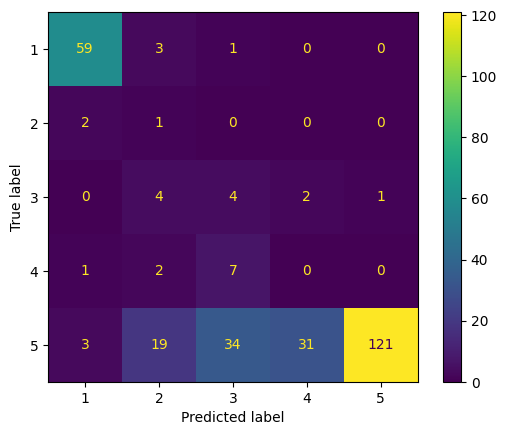

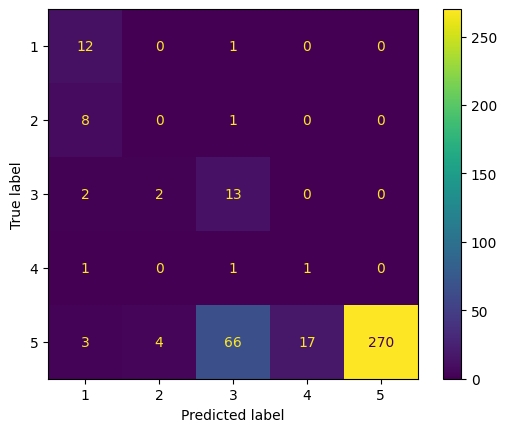

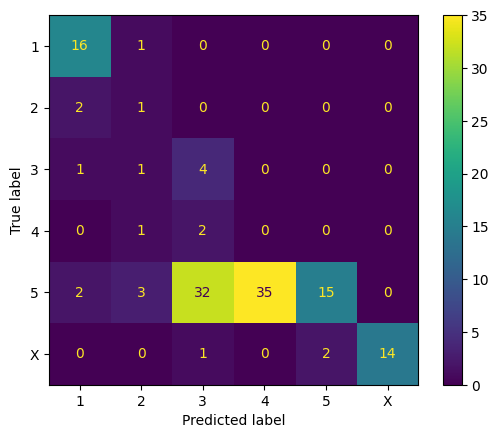

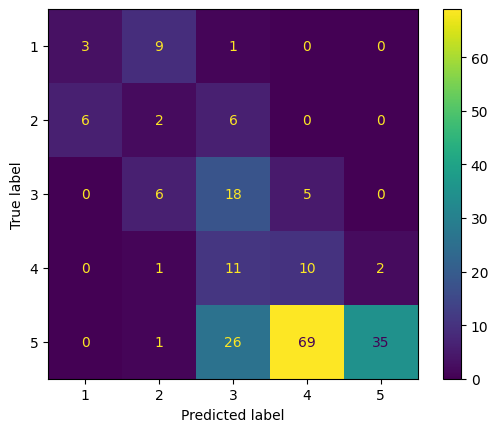

In [14]:
import json
with open('results/chatgpt_results.txt', 'w') as f:
    for aspect, df in results.items():
        f.write(f'Agreement Statistics for {aspect}\n')
        f.write(f' Total number of samples: {len(df)}\n')
        ## get the prompt type
        
        prompt_type = 'definitions_incontext_learning'

        for type in [prompt_type]:
            gold_labels = []
            chatgpt_labels = []
            for index, row in df.iterrows():
                
                gold_label = row[f'{aspect}_label']
                chatgpt_label = row[f'chatgpt_{aspect}_score']
                chatgpt_label = str(chatgpt_label)
                if chatgpt_label.lower() in ['na','nan']:
                    continue

                ## if the labels are numeric, convert them to string
                if str(gold_label).lower() not in ['x', 'no claim']:
                    gold_label = str(int(float(gold_label)))
                else:
                    gold_label = 'X'
                if str(chatgpt_label).lower() not in ['x', 'no claim']:
                    ## extract the number from the string
                    chatgpt_label = ''.join(filter(str.isdigit, chatgpt_label))


                    chatgpt_label = str(int(float(chatgpt_label)))
                else:
                    chatgpt_label = 'X'

                gold_labels.append(gold_label)
                chatgpt_labels.append(chatgpt_label)

            f.write(f' Agreement Statistics for {type}\n')
            ## for verifiability we have one mroe measure
            if aspect == 'verifiability':
                accuracy,f1, kappa, kappa_linear, kappa_quadratic, spearman, f1_X,accuracy_f1 = get_stats(gold=gold_labels, pred=chatgpt_labels, aspect=aspect)
            else:
                accuracy,f1, kappa, kappa_linear, kappa_quadratic, spearman = get_stats(gold=gold_labels, pred=chatgpt_labels, aspect=aspect)
            
            f.write(f' F1 Score: {f1:.2f}\n')
            f.write(f' Kappa Score: {kappa:.2f}\n')
            f.write(f' Linear Kappa Score: {kappa_linear:.2f}\n')
            f.write(f' Quadratic Kappa Score: {kappa_quadratic:.2f}\n')
            f.write(f' Spearman Correlation: {spearman.correlation:.2f}\n')
            if aspect == 'verifiability':
                f.write(f' F1 Score for X: {f1_X:.2f}\n')

            ## print confusion matrix
            cm = confusion_matrix(gold_labels, chatgpt_labels)
            display_labels = [1,2,3,4,5]
            if aspect == 'verifiability':
                display_labels = display_labels + ['X']
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
            print(f'Confusion Matrix for {aspect} {type}')
            disp.plot()
            ## flush the plot
            f.write(f'Confusion Matrix\n')
            f.write(f'{disp.confusion_matrix}\n')

            
            f.write('-' * 50 + '\n')
                
        f.write('=' * 50 + '\n')
        


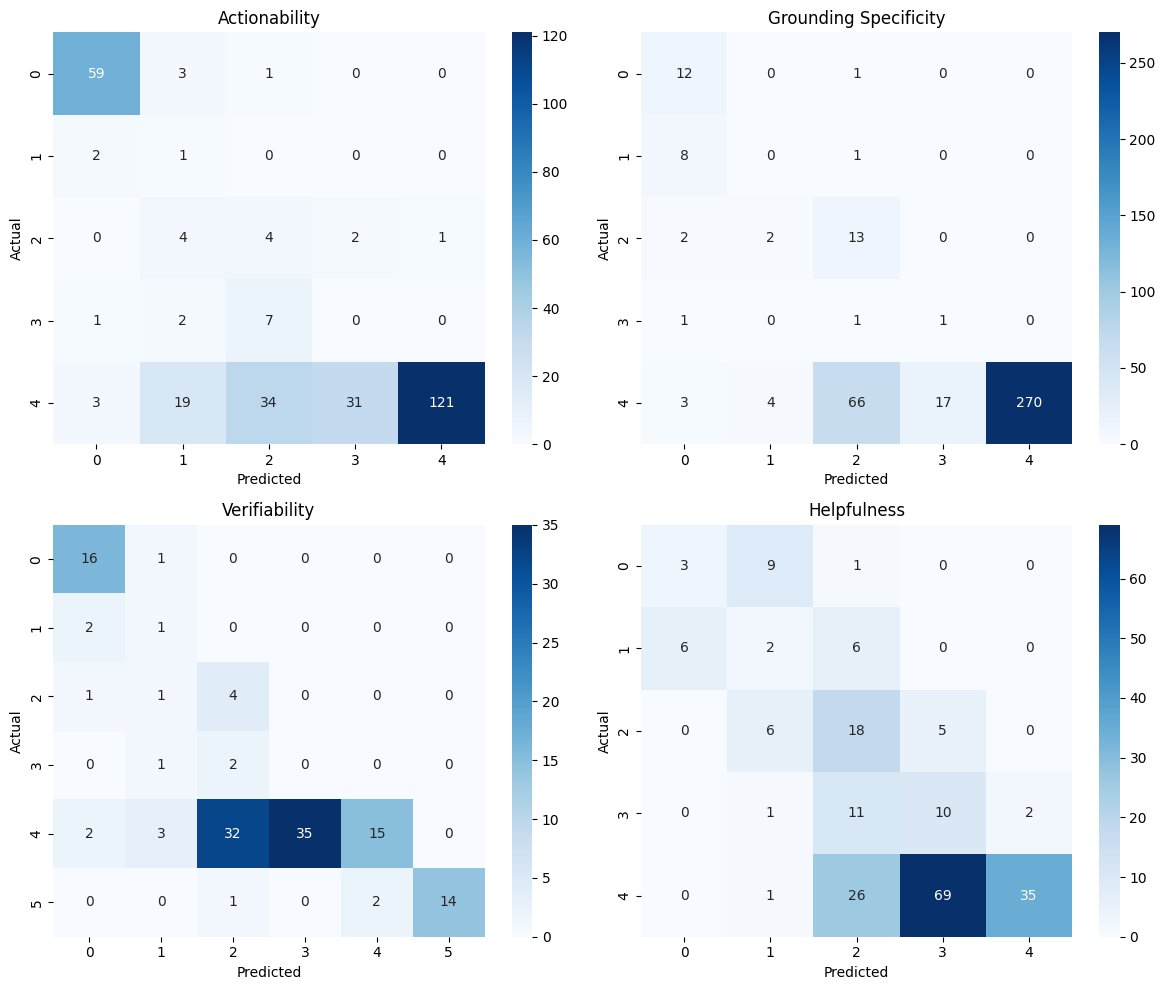

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define confusion matrices and their titles
confusion_matrices = {
    "Actionability": np.array([[59, 3, 1, 0, 0],
                                [2, 1, 0, 0, 0],
                                [0, 4, 4, 2, 1],
                                [1, 2, 7, 0, 0],
                                [3, 19, 34, 31, 121]]),
    "Grounding Specificity": np.array([[12, 0, 1, 0, 0],
                                        [8, 0, 1, 0, 0],
                                        [2, 2, 13, 0, 0],
                                        [1, 0, 1, 1, 0],
                                        [3, 4, 66, 17, 270]]),
    "Verifiability": np.array([[16, 1, 0, 0, 0, 0],
                                [2, 1, 0, 0, 0, 0],
                                [1, 1, 4, 0, 0, 0],
                                [0, 1, 2, 0, 0, 0],
                                [2, 3, 32, 35, 15, 0],
                                [0, 0, 1, 0, 2, 14]]),
    "Helpfulness": np.array([[3, 9, 1, 0, 0],
                              [6, 2, 6, 0, 0],
                              [0, 6, 18, 5, 0],
                              [0, 1, 11, 10, 2],
                              [0, 1, 26, 69, 35]])
}

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each confusion matrix
for i, (title, matrix) in enumerate(confusion_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('gold_labels_confusion_matrices.pdf')
plt.show()
#####3 save it as pdf
